# **Fera Formidável 4.2**

* Caio M. C. Ruas - RM: 24010
* Thalles José de S. Cansi - RM: 24006

## Introdução

Nessa fera, o objetivo era implementar uma estratégia de parada antecipada em uma rede neural feita em python puro ou no processo desenvolvido em disciplina envolvendo o `PyTorch`.

Em redes neurais, treinar por um número excessivo de épocas pode levar ao overfitting. Isso significa que a rede começa a memorizar os dados de treinamento, incluindo ruídos e detalhes específicos, em vez de aprender os padrões gerais. Como resultado, o desempenho em dados de treinamento melhora continuamente, mas a capacidade de generalizar para dados novos e não vistos diminui significativamente.

Para evitar o overfitting, uma técnica eficaz é a parada antecipada (early stopping). Durante o treinamento, além do conjunto de treinamento, utilizamos um conjunto de validação, que a rede nunca viu antes. Monitoramos o desempenho da rede nesse conjunto de validação a cada época. Inicialmente, o desempenho tanto no treinamento quanto na validação tende a melhorar. No entanto, se o desempenho no conjunto de validação para de melhorar ou começa a piorar enquanto o desempenho no treinamento continua a aumentar, isso indica que o overfitting está começando a ocorrer. Nesse ponto, aplicamos a parada antecipada, interrompendo o treinamento para "capturar" o modelo em um estado onde ele ainda generaliza bem, antes de se especializar demais nos dados de treinamento.

Sendo assim, será aplicado o conceito de parada antecipada em uma rede neural simples, modificando o código da rede neural em python puro feito na disciplina.

**Observação:** A rede neural feita durante a disciplina foi utilizada como base para a implementação das novas funções de ativação. Neste notebook, está presente apenas a versão adaptada ao objetivo da atividade, com as funções de ativação modificadas. A versão original da rede neural pode ser encontrada em `colocar link git`

### Rede Neural Modificada

In [165]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __gt__(self, outro_valor):
        """Realiza a operação: self > outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data > outro_valor.data else 0.0
        return Valor(data)
    
    def __ge__(self, outro_valor):
        """Realiza a operação: self >= outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data >= outro_valor.data else 0.0
        return Valor(data)

    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [166]:
import random

class Neuronio:
    def __init__(self, num_dados_entrada, funcao_ativacao):
        self.vies = Valor(random.uniform(-1, 1))
        self.funcao = funcao_ativacao
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies
          
        if self.funcao == "sig":
            dado_de_saida = soma.sig()
        elif self.funcao == "relu":
            dado_de_saida = soma * (soma > Valor(0))
        elif self.funcao == "binary_injecito":
            dado_de_saida = (soma >= Valor(0)) * 1 + (soma < Valor(0)) * 0
        elif self.funcao == "selu":
            dado_de_saida = soma * (soma >= Valor(0)) + 1.0507 * (math.exp(soma) - 1) * (soma < Valor(0))
        else:
            raise ValueError(f"Função de ativação {self.funcao} não reconhecida.")

        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

In [167]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada, funcao_ativacao):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada, funcao_ativacao)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [168]:
class MLP():
    def __init__(self, num_dados_entrada, num_neuronios_por_camada, funcao_ativacao):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i], funcao_ativacao)
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

### Atividade

Para implementar a parada antecipada, foi necessário modificar a função responsável pelo treinamento da rede neural em épocas. A ideia é monitorar o desempenho da rede em um conjunto de validação e interromper o treinamento quando o desempenho começar a piorar.

In [169]:
def otimizacao_em_epocas(mlp, x_train, y_true_train, x_val, y_true_val, num_epocas, taxa_de_aprendizado):
    """
    Realiza a otimização do MLP em épocas, utilizando o algoritmo de backpropagation.
    """

    train_losses = []
    val_losses = []

    for epoca in range(num_epocas):

        #   Parada antecipada
        if len(val_losses) > 2 and val_losses[-1] > val_losses[-2]:
            print("Validação: Aumento do erro, interrompendo treinamento.")
            return train_losses, val_losses

        #   Forward pass (treino)
        y_pred_train = []
        for exemplo in x_train:
            previsao = mlp(exemplo)
            y_pred_train.append(previsao)  #   Armazena apenas o valor escalar

        y_pred_train = [pred[0] for pred in y_pred_train]

        #   Loss (treino)
        erros_train = []
        for yt, yp in zip(y_true_train, y_pred_train):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_train.append(erro_quadratico)
        loss_train = sum(erros_train)

        #   Forward pass (validação)
        y_pred_val = []
        for exemplo in x_val:
            previsao = mlp(exemplo)
            y_pred_val.append(previsao)  #   Armazena apenas o valor escalar

        y_pred_val = [pred[0] for pred in y_pred_val]

        #   Loss (validação)
        erros_val = []
        for yt, yp in zip(y_true_val, y_pred_val):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_val.append(erro_quadratico)
        loss_val = sum(erros_val)

        #   Zero grad
        for p in mlp.parametros():
            p.grad = 0

        #   Backpropagation
        loss_train.propagar_tudo()  #   Propaga o gradiente a partir do loss de treino

        #   Atualiza parâmetros
        for p in mlp.parametros():
            p.data = p.data - p.grad * taxa_de_aprendizado

        #   Armazena os valores de loss
        train_losses.append(loss_train.data)
        val_losses.append(loss_val.data)

        #   Mostra resultado (opcional)
        print(f"Época {epoca}, Loss Treino: {loss_train.data:.4f}, Loss Validação: {loss_val.data:.4f}")
    
    return train_losses, val_losses

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

np.random.seed(42)
num_samples = 1000
x = np.linspace(0, 10, num_samples)
y = np.sin(x) + np.random.normal(0, 0.1, num_samples)  #   Seno com ruído
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scale = scaler_x.fit_transform(x)
y_scale = scaler_y.fit_transform(y)

x_scaled = x_scale.tolist()
y_scaled = y_scale.tolist()
(print(f"Dados de entrada: {x_scaled}"))

Dados de entrada: [[0.0], [0.001001001001001001], [0.002002002002002002], [0.003003003003003003], [0.004004004004004004], [0.005005005005005005], [0.006006006006006006], [0.007007007007007008], [0.008008008008008008], [0.009009009009009009], [0.01001001001001001], [0.011011011011011013], [0.012012012012012012], [0.013013013013013015], [0.014014014014014016], [0.015015015015015017], [0.016016016016016016], [0.01701701701701702], [0.018018018018018018], [0.01901901901901902], [0.02002002002002002], [0.021021021021021023], [0.022022022022022025], [0.023023023023023025], [0.024024024024024024], [0.02502502502502503], [0.02602602602602603], [0.02702702702702703], [0.02802802802802803], [0.02902902902902903], [0.030030030030030033], [0.031031031031031032], [0.03203203203203203], [0.03303303303303303], [0.03403403403403404], [0.035035035035035036], [0.036036036036036036], [0.037037037037037035], [0.03803803803803804], [0.03903903903903904], [0.04004004004004004], [0.041041041041041046], [0.04

In [171]:
x_train, x_val, y_train, y_val = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

for i in range(len(y_val)):
    y_val[i] = y_val[i][0]
for i in range(len(y_train)):
    y_train[i] = y_train[i][0]

In [188]:
num_dados_entrada = 1
num_neuronios_por_camada = [10, 10]
funcao_ativacao = "sig"
mlp = MLP(num_dados_entrada, num_neuronios_por_camada, funcao_ativacao)

num_epocas = 1000
taxa_de_aprendizado = 0.005
train_losses, val_losses = otimizacao_em_epocas(mlp, x_train, y_train, x_val, y_val, num_epocas, taxa_de_aprendizado)

Época 0, Loss Treino: 63.1159, Loss Validação: 13.5272
Época 1, Loss Treino: 63.1332, Loss Validação: 13.4654
Época 2, Loss Treino: 63.2621, Loss Validação: 13.5651
Validação: Aumento do erro, interrompendo treinamento.


Dados de treino:
[[0.02902902902902903], [0.5355355355355356], [0.6956956956956958], [0.5575575575575575], [0.836836836836837], [0.5965965965965966], [0.1651651651651652], [0.918918918918919], [0.49549549549549554], [0.8248248248248249], [0.06506506506506507], [0.14114114114114115], [0.925925925925926], [0.8278278278278279], [0.6556556556556558], [0.33133133133133136], [0.6646646646646648], [0.24924924924924927], [0.907907907907908], [0.7087087087087087], [0.3053053053053053], [0.7347347347347348], [0.9759759759759761], [0.049049049049049054], [0.896896896896897], [0.002002002002002002], [0.5445445445445446], [0.3503503503503504], [0.9049049049049049], [0.5365365365365365], [0.34434434434434436], [0.994994994994995], [0.4814814814814815], [0.5755755755755756], [0.03303303303303303], [0.031031031031031032], [0.23123123123123124], [0.963963963963964], [0.1921921921921922], [0.33333333333333337], [0.003003003003003003], [0.20420420420420424], [0.5145145145145146], [0.7997997997997999], [0

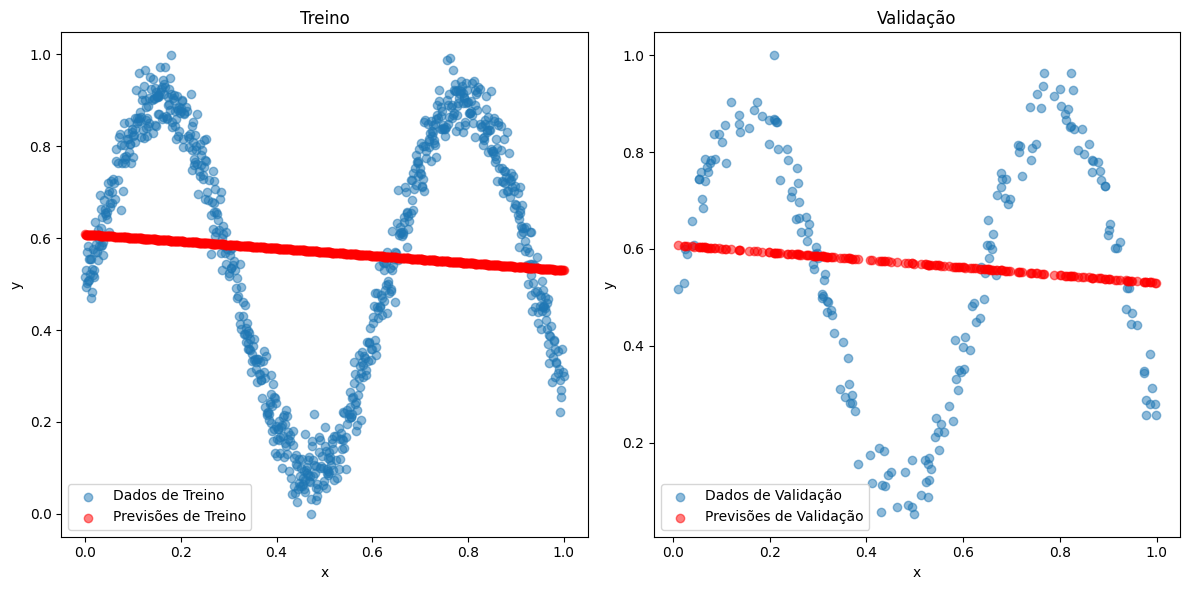

In [186]:
y_pred_train = []
for exemplo in x_train:
    previsao = mlp(exemplo)
    y_pred_train.append(previsao)
y_pred_train = [pred[0] for pred in y_pred_train]
for i in range(len(y_pred_train)):
    y_pred_train[i] = y_pred_train[i].data

y_pred_val = []
for exemplo in x_val:
    previsao = mlp(exemplo)
    y_pred_val.append(previsao)
y_pred_val = [pred[0] for pred in y_pred_val]
for i in range(len(y_pred_val)):
    y_pred_val[i] = y_pred_val[i].data

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, label="Dados de Treino", alpha=0.5)
plt.scatter(x_train, y_pred_train, label="Previsões de Treino", color='red', alpha=0.5)
plt.title("Treino")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x_val, y_val, label="Dados de Validação", alpha=0.5)
plt.scatter(x_val, y_pred_val, label="Previsões de Validação", color='red', alpha=0.5)
plt.title("Validação")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusão



## Referências

$^{[1]}$ BKASHYAP, P. Early Stopping in Deep Learning: A Simple Guide to Prevent Overfitting. Disponível em: <https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e>. 

$^{[2]}$ 

$^{[3]}$ 